In [1]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)
# from tensorflow import keras as keras 

from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(123)

1.15.0
2.3.1


Using TensorFlow backend.


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('Dane/adult/adult.data', sep=", ",header = None)
test_set = pd.read_csv('Dane/adult/adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  import sys


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

# EarlyStopping

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Adam = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss="binary_crossentropy",optimizer=Adam, metrics=["accuracy"])

save_best_model = ModelCheckpoint("wagi_best.h5py",save_best_only=True)
lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, save_best_model, early_stopping])


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               4200      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 30162 samples, validate on 15060 samples
Epoch 1/100
30162/30162 

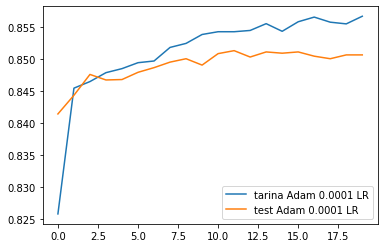

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam 0.0001 LR")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam 0.0001 LR")


plt.legend()
plt.show()

In [6]:
model.load_weights("wagi_best.h5py")
model.evaluate(X_test,y_test)

15060/15060 [==============================] - 0s 12us/step


[0.3174618803726566, 0.8504648208618164]

# Zad.
Do poniższych danych dobierz paametr
```python
patience=
```

Zwizualizuj wyniki dla obu modeli.

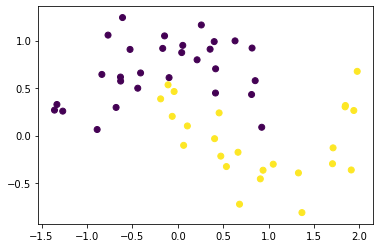

In [7]:
from sklearn.datasets import make_moons
# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)
# split into train and test
# n_train = 30
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=2)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [8]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1000)              3000      
_________________________________________________________________
dense_6 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_7 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.7113 - accuracy: 0.5094 - val_loss: 0.7198 - val_accuracy: 0.4468
Epoch 2/1000
53/53 [==============================] - 0s 548

53/53 [==============================] - 0s 295us/step - loss: 0.0697 - accuracy: 0.9811 - val_loss: 0.2211 - val_accuracy: 0.9149
Epoch 108/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0663 - accuracy: 0.9811 - val_loss: 0.2228 - val_accuracy: 0.9149
Epoch 109/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0638 - accuracy: 0.9811 - val_loss: 0.2214 - val_accuracy: 0.9149
Epoch 110/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0632 - accuracy: 0.9811 - val_loss: 0.2157 - val_accuracy: 0.9149
Epoch 111/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0589 - accuracy: 1.0000 - val_loss: 0.1998 - val_accuracy: 0.9149
Epoch 112/1000
53/53 [==============================] - 0s 653us/step - loss: 0.0579 - accuracy: 1.0000 - val_loss: 0.1921 - val_accuracy: 0.9149
Epoch 113/1000
53/53 [==============================] - 0s 623us/step - loss: 0.0601 - accuracy: 1.0000 - val_loss: 0.1882 - val_accuracy: 

53/53 [==============================] - 0s 585us/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1894 - val_accuracy: 0.9362
Epoch 220/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.1906 - val_accuracy: 0.9362
Epoch 221/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1930 - val_accuracy: 0.9149
Epoch 222/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1958 - val_accuracy: 0.9149
Epoch 223/1000
53/53 [==============================] - 0s 585us/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 0.1964 - val_accuracy: 0.9149
Epoch 224/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1969 - val_accuracy: 0.9149
Epoch 225/1000
53/53 [==============================] - 0s 585us/step - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.1964 - val_accuracy: 

53/53 [==============================] - 0s 566us/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.2223 - val_accuracy: 0.9149
Epoch 332/1000
53/53 [==============================] - 0s 585us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2220 - val_accuracy: 0.9149
Epoch 333/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.2220 - val_accuracy: 0.9149
Epoch 334/1000
53/53 [==============================] - 0s 642us/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.2217 - val_accuracy: 0.9149
Epoch 335/1000
53/53 [==============================] - 0s 585us/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.2224 - val_accuracy: 0.9149
Epoch 336/1000
53/53 [==============================] - 0s 569us/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.2236 - val_accuracy: 0.9149
Epoch 337/1000
53/53 [==============================] - 0s 544us/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.2241 - val_accuracy: 

Epoch 443/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2492 - val_accuracy: 0.9149
Epoch 444/1000
53/53 [==============================] - 0s 585us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2513 - val_accuracy: 0.9149
Epoch 445/1000
53/53 [==============================] - 0s 585us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2528 - val_accuracy: 0.9149
Epoch 446/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2534 - val_accuracy: 0.9149
Epoch 447/1000
53/53 [==============================] - 0s 585us/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2518 - val_accuracy: 0.9149
Epoch 448/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2511 - val_accuracy: 0.9149
Epoch 449/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2498 -

Epoch 499/1000
53/53 [==============================] - 0s 566us/step - loss: 9.9509e-04 - accuracy: 1.0000 - val_loss: 0.2606 - val_accuracy: 0.9149
Epoch 500/1000
53/53 [==============================] - 0s 566us/step - loss: 9.4830e-04 - accuracy: 1.0000 - val_loss: 0.2610 - val_accuracy: 0.9149
Epoch 501/1000
53/53 [==============================] - 0s 566us/step - loss: 9.3451e-04 - accuracy: 1.0000 - val_loss: 0.2620 - val_accuracy: 0.9149
Epoch 502/1000
53/53 [==============================] - 0s 566us/step - loss: 9.2502e-04 - accuracy: 1.0000 - val_loss: 0.2627 - val_accuracy: 0.9149
Epoch 503/1000
53/53 [==============================] - 0s 566us/step - loss: 9.2200e-04 - accuracy: 1.0000 - val_loss: 0.2633 - val_accuracy: 0.9149
Epoch 504/1000
53/53 [==============================] - 0s 585us/step - loss: 9.1923e-04 - accuracy: 1.0000 - val_loss: 0.2638 - val_accuracy: 0.9149
Epoch 505/1000
53/53 [==============================] - 0s 604us/step - loss: 9.3776e-04 - accuracy:

Epoch 608/1000
53/53 [==============================] - 0s 585us/step - loss: 5.6535e-04 - accuracy: 1.0000 - val_loss: 0.2838 - val_accuracy: 0.9149
Epoch 609/1000
53/53 [==============================] - 0s 566us/step - loss: 5.5743e-04 - accuracy: 1.0000 - val_loss: 0.2850 - val_accuracy: 0.9149
Epoch 610/1000
53/53 [==============================] - 0s 585us/step - loss: 5.5847e-04 - accuracy: 1.0000 - val_loss: 0.2855 - val_accuracy: 0.9149
Epoch 611/1000
53/53 [==============================] - 0s 585us/step - loss: 5.7069e-04 - accuracy: 1.0000 - val_loss: 0.2859 - val_accuracy: 0.9149
Epoch 612/1000
53/53 [==============================] - 0s 566us/step - loss: 5.5440e-04 - accuracy: 1.0000 - val_loss: 0.2850 - val_accuracy: 0.9149
Epoch 613/1000
53/53 [==============================] - 0s 585us/step - loss: 5.4673e-04 - accuracy: 1.0000 - val_loss: 0.2831 - val_accuracy: 0.9149
Epoch 614/1000
53/53 [==============================] - 0s 623us/step - loss: 5.4915e-04 - accuracy:

Epoch 717/1000
53/53 [==============================] - 0s 604us/step - loss: 3.7988e-04 - accuracy: 1.0000 - val_loss: 0.3050 - val_accuracy: 0.9149
Epoch 718/1000
53/53 [==============================] - 0s 642us/step - loss: 3.7824e-04 - accuracy: 1.0000 - val_loss: 0.3041 - val_accuracy: 0.9149
Epoch 719/1000
53/53 [==============================] - 0s 604us/step - loss: 3.6615e-04 - accuracy: 1.0000 - val_loss: 0.3041 - val_accuracy: 0.9149
Epoch 720/1000
53/53 [==============================] - 0s 585us/step - loss: 3.7121e-04 - accuracy: 1.0000 - val_loss: 0.3038 - val_accuracy: 0.9149
Epoch 721/1000
53/53 [==============================] - 0s 585us/step - loss: 3.7381e-04 - accuracy: 1.0000 - val_loss: 0.3047 - val_accuracy: 0.9149
Epoch 722/1000
53/53 [==============================] - 0s 604us/step - loss: 3.7185e-04 - accuracy: 1.0000 - val_loss: 0.3042 - val_accuracy: 0.9149
Epoch 723/1000
53/53 [==============================] - 0s 623us/step - loss: 3.6065e-04 - accuracy:

Epoch 826/1000
53/53 [==============================] - 0s 604us/step - loss: 2.5345e-04 - accuracy: 1.0000 - val_loss: 0.3214 - val_accuracy: 0.9149
Epoch 827/1000
53/53 [==============================] - 0s 604us/step - loss: 2.6212e-04 - accuracy: 1.0000 - val_loss: 0.3229 - val_accuracy: 0.9149
Epoch 828/1000
53/53 [==============================] - 0s 604us/step - loss: 2.5324e-04 - accuracy: 1.0000 - val_loss: 0.3231 - val_accuracy: 0.9149
Epoch 829/1000
53/53 [==============================] - 0s 623us/step - loss: 2.5626e-04 - accuracy: 1.0000 - val_loss: 0.3227 - val_accuracy: 0.9149
Epoch 830/1000
53/53 [==============================] - 0s 585us/step - loss: 2.5072e-04 - accuracy: 1.0000 - val_loss: 0.3230 - val_accuracy: 0.9149
Epoch 831/1000
53/53 [==============================] - 0s 604us/step - loss: 2.5003e-04 - accuracy: 1.0000 - val_loss: 0.3231 - val_accuracy: 0.9149
Epoch 832/1000
53/53 [==============================] - 0s 604us/step - loss: 2.5225e-04 - accuracy:

Epoch 935/1000
53/53 [==============================] - 0s 566us/step - loss: 1.8315e-04 - accuracy: 1.0000 - val_loss: 0.3376 - val_accuracy: 0.9149
Epoch 936/1000
53/53 [==============================] - 0s 566us/step - loss: 1.8278e-04 - accuracy: 1.0000 - val_loss: 0.3375 - val_accuracy: 0.9149
Epoch 937/1000
53/53 [==============================] - 0s 566us/step - loss: 1.8526e-04 - accuracy: 1.0000 - val_loss: 0.3376 - val_accuracy: 0.9149
Epoch 938/1000
53/53 [==============================] - 0s 566us/step - loss: 1.8167e-04 - accuracy: 1.0000 - val_loss: 0.3385 - val_accuracy: 0.9149
Epoch 939/1000
53/53 [==============================] - 0s 566us/step - loss: 1.8557e-04 - accuracy: 1.0000 - val_loss: 0.3396 - val_accuracy: 0.9149
Epoch 940/1000
53/53 [==============================] - 0s 566us/step - loss: 1.8078e-04 - accuracy: 1.0000 - val_loss: 0.3396 - val_accuracy: 0.9149
Epoch 941/1000
53/53 [==============================] - 0s 566us/step - loss: 1.8237e-04 - accuracy:

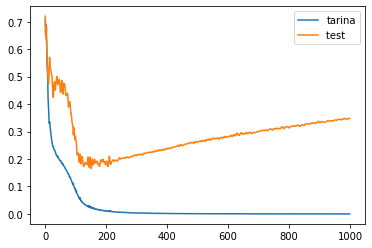

In [9]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


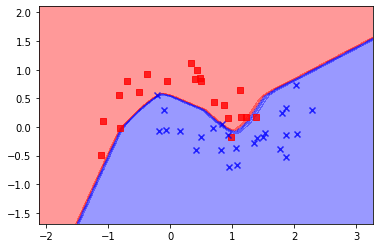

In [10]:
from help_plot import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

# Zad

Do powyższego modelu dodaj EarlyStopping:

```python
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1)
```